In [1]:
import glob

import imageio
import numpy as np
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

from functions.image import remove_noise_satellite

In [12]:
examples = glob.glob("./examples/*/*.png", recursive=True)
images = []
labels = []

valid = ["windmills", "boats", "ocean", "beach"]
count = {}
for v in valid:
    count[v] = 0

for path in examples:

    category = path.split("/")[2]
    if category not in valid:
        continue

    if count[category] >= 150:
        continue
    count[category] += 1

    src = imageio.imread(path)
    src = np.expand_dims(remove_noise_satellite(src) / 255.0, -1)

    # import images oriented 4 ways
    for i in range(4):
        images.append(np.rot90(src.copy(), i))
        labels.append(valid.index(category))

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
x_train = np.stack(x_train)
x_test = np.stack(x_test)
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

In [14]:
# model used throughout project, best results
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, epochs=150, verbose=False)

In [15]:
model.evaluate(x_test, y_test, verbose=2)

15/15 - 0s - loss: 0.5647 - accuracy: 0.8167 - 37ms/epoch - 2ms/step


[0.5646714568138123, 0.8166666626930237]

In [16]:
from functions.visual import plot_loss, plot_accuracy

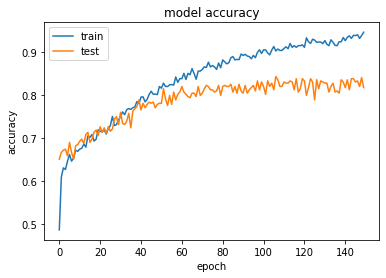

In [17]:
plot_accuracy(history)

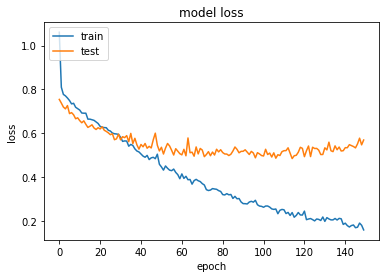

In [18]:
plot_loss(history)

<AxesSubplot:>

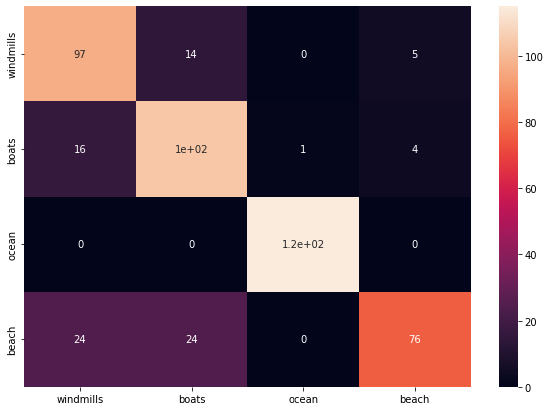

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
cm = confusion_matrix([np.argmax(a) for a in y_test], [np.argmax(a) for a in y_pred])
df_cm = pd.DataFrame(cm, index=valid, columns=valid)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)